In [1]:
import torch
print(torch.version.cuda)  # Shows CUDA version used by PyTorch
print(torch.backends.cudnn.version())  # Shows cuDNN version
print(torch.cuda.get_device_name(0))  # Shows GPU model
print(torch.cuda.get_device_capability(0))  # Shows GPU compute capability

12.4
90100
NVIDIA GeForce RTX 2080 Ti
(7, 5)


In [47]:
import os
import random
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torch.nn.functional as F

# Dataset Paths
dataset_path = "few_shot_dataset"
support_path = os.path.join(dataset_path, "support_set")
query_path = os.path.join(dataset_path, "query_set")

# Hyperparameters
BATCH_SIZE = 1  # One episode at a time
EPOCHS = 3
EPISODES_PER_EPOCH = 50  # Number of episodes per epoch
LEARNING_RATE = 0.001
IMG_SIZE = (224, 224)
N_WAY = len(os.listdir(support_path))  # Number of classes per episode (5 classes)
K_SHOT = 7  # Number of support images per class
Q_QUERY = 15  # Number of query images per class

# Image Transformations
default_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Prototypical Dataset
class PrototypicalDataset(Dataset):
    def __init__(self, support_dir, query_dir, transform=None):
        self.transform = transform or default_transform
        self.classes = os.listdir(support_dir)
        self.support_images = {cls: [os.path.join(support_dir, cls, img) for img in os.listdir(os.path.join(support_dir, cls))] for cls in self.classes}
        self.query_images = {cls: [os.path.join(query_dir, cls, img) for img in os.listdir(os.path.join(query_dir, cls))] for cls in self.classes}

    def __len__(self):
        return EPISODES_PER_EPOCH  # Number of episodes per epoch

    def __getitem__(self, idx):
        sampled_classes = random.sample(self.classes, N_WAY)  # Select 5 classes
        support_set, query_set, labels = [], [], []

        label_map = {cls: i for i, cls in enumerate(sampled_classes)}
        
        for cls in sampled_classes:
            support_samples = random.sample(self.support_images[cls], min(K_SHOT, len(self.support_images[cls])))
            query_samples = random.sample(self.query_images[cls], min(Q_QUERY, len(self.query_images[cls])))

            
            support_set.extend([(img, label_map[cls]) for img in support_samples])
            query_set.extend([(img, label_map[cls]) for img in query_samples])

        def load_images(image_list):
            images, labels = [], []
            for img_path, lbl in image_list:
                img = Image.open(img_path).convert("RGB")
                images.append(self.transform(img))
                labels.append(lbl)
            return torch.stack(images), torch.tensor(labels)
        
        support_imgs, support_labels = load_images(support_set)
        query_imgs, query_labels = load_images(query_set)
        
        return (support_imgs, support_labels, query_imgs, query_labels)

# Prototypical Network Class
class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super(PrototypicalNetwork, self).__init__()
        self.encoder = models.resnet50(pretrained=True)
        self.encoder.fc = nn.Identity()  # Remove final FC layer

    def forward(self, x):
        return self.encoder(x)

# Compute Prototypes
def compute_prototypes(support_imgs, support_labels, model):
    with torch.no_grad():
        embeddings = model(support_imgs)  # Shape: (N_WAY * K_SHOT, 2048)
    prototypes = []
    for cls in range(N_WAY):
        cls_embeddings = embeddings[support_labels == cls]
        prototypes.append(cls_embeddings.mean(dim=0))
    return torch.stack(prototypes)  # Shape: (N_WAY, 2048)

# Training Function
def train():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = PrototypicalNetwork().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    dataset = PrototypicalDataset(support_path, query_path)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    model.train()
    for epoch in range(EPOCHS):
        total_loss, correct, total = 0, 0, 0
        print(f"\nEpoch {epoch+1}/{EPOCHS}")

        for episode, (support_imgs, support_labels, query_imgs, query_labels) in enumerate(dataloader):
            support_imgs, support_labels = support_imgs.squeeze(0).to(device), support_labels.squeeze(0).to(device)
            query_imgs, query_labels = query_imgs.squeeze(0).to(device), query_labels.squeeze(0).to(device)

            optimizer.zero_grad()
            prototypes = compute_prototypes(support_imgs, support_labels, model)
            query_embeddings = model(query_imgs)

            # Compute distances to prototypes
            dists = torch.cdist(query_embeddings, prototypes)  # (Q_QUERY * N_WAY, N_WAY)
            preds = torch.argmin(dists, dim=1)

            # Loss: Softmax over negative distances
            loss = F.cross_entropy(-dists, query_labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (preds == query_labels).sum().item()
            total += len(query_labels)

            if episode % 10 == 0:
                acc = correct / total
                print(f"  Episode {episode}: Loss = {loss.item():.4f}, Accuracy = {acc:.4f}")

        print(f"Epoch {epoch+1} -> Loss: {total_loss / len(dataloader):.4f}, Accuracy: {correct / total:.4f}")

    torch.save(model.state_dict(), "prototypical_network.pth")
    print("Model saved!")

# Run Training
train()


/home/mcw/miniconda3/envs/ad-env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mcw/miniconda3/envs/ad-env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1/3
  Episode 0: Loss = 0.1304, Accuracy = 0.9600
  Episode 10: Loss = 0.1818, Accuracy = 0.9467
  Episode 20: Loss = 0.0185, Accuracy = 0.9581
  Episode 30: Loss = 0.0089, Accuracy = 0.9682
  Episode 40: Loss = 0.0439, Accuracy = 0.9743
Epoch 1 -> Loss: 0.0793, Accuracy: 0.9779

Epoch 2/3
  Episode 0: Loss = 0.0038, Accuracy = 1.0000
  Episode 10: Loss = 0.0548, Accuracy = 0.9794
  Episode 20: Loss = 0.0006, Accuracy = 0.9873
  Episode 30: Loss = 0.0008, Accuracy = 0.9897
  Episode 40: Loss = 0.0019, Accuracy = 0.9909
Epoch 2 -> Loss: 0.0342, Accuracy: 0.9917

Epoch 3/3
  Episode 0: Loss = 0.0033, Accuracy = 1.0000
  Episode 10: Loss = 0.1937, Accuracy = 0.9491
  Episode 20: Loss = 0.5748, Accuracy = 0.9117
  Episode 30: Loss = 0.2278, Accuracy = 0.8903
  Episode 40: Loss = 0.2565, Accuracy = 0.8972
Epoch 3 -> Loss: 0.2528, Accuracy: 0.9128
Model saved!


Processing support set...


100%|██████████| 5/5 [00:00<00:00, 10.27it/s]


Processing query set...


100%|██████████| 5/5 [00:00<00:00,  7.45it/s]
/home/mcw/miniconda3/envs/ad-env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/mcw/miniconda3/envs/ad-env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/mcw/miniconda3/envs/ad-env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Applying UMAP dimensionality reduction...


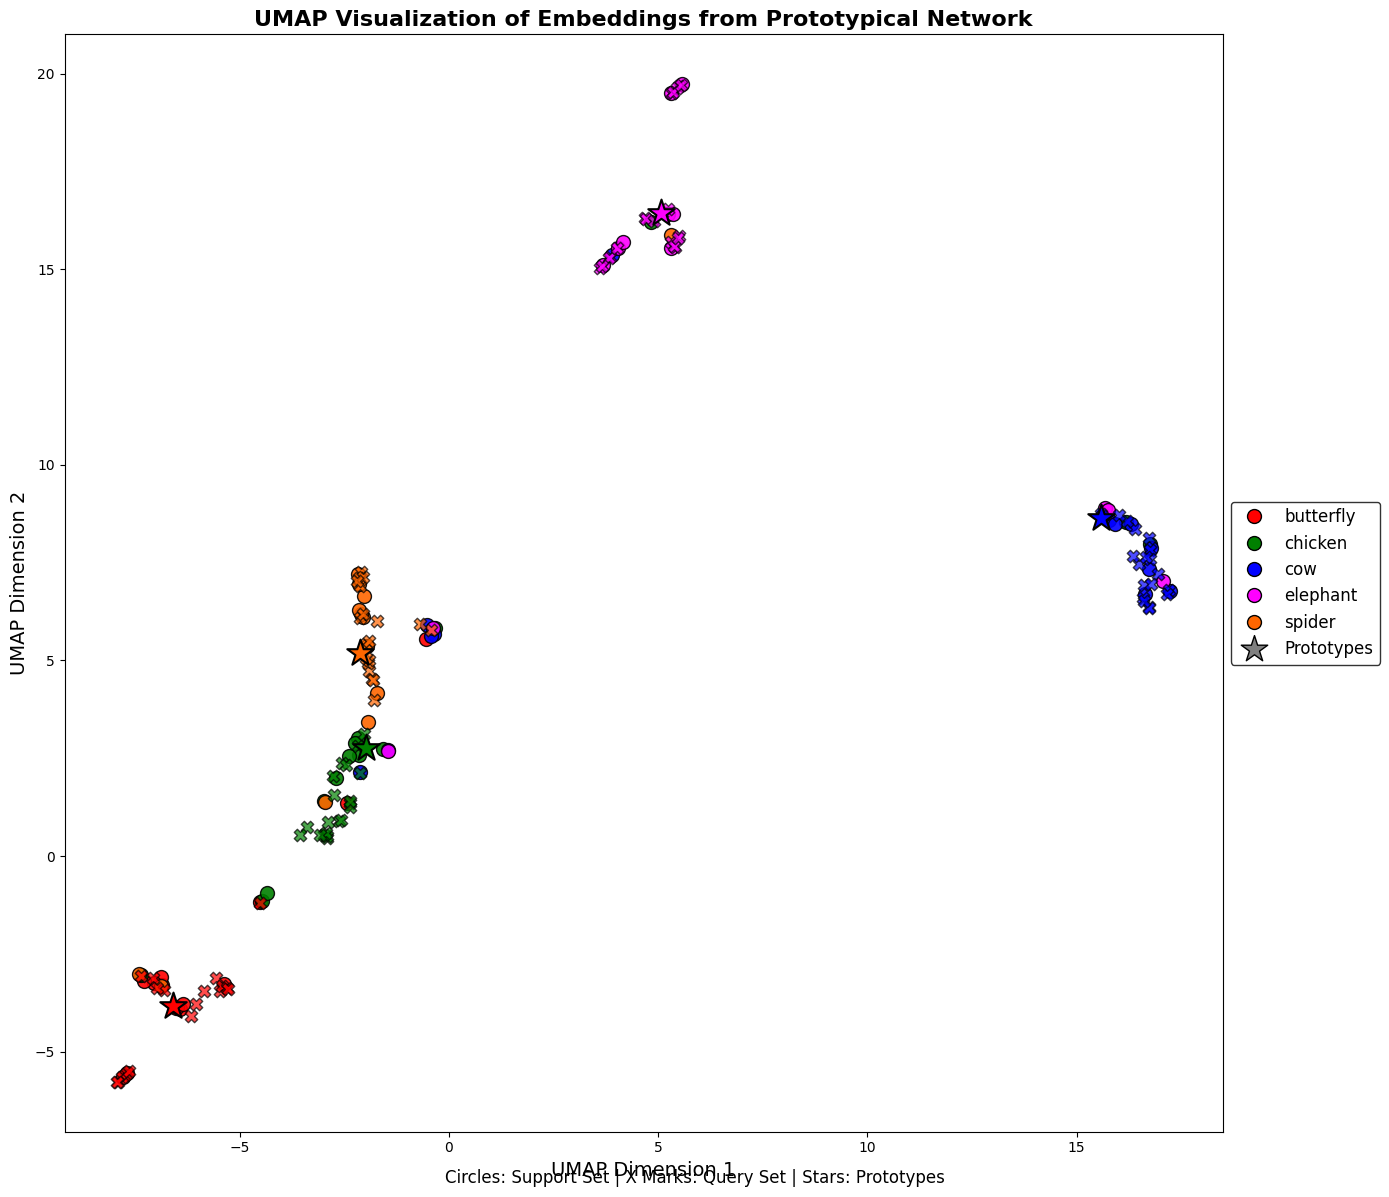

UMAP visualization with bright colors on white background saved as 'prototypical_network_umap_bright.png'


In [48]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import umap
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

# Define paths
dataset_path = "few_shot_dataset"
support_path = os.path.join(dataset_path, "support_set")
query_path = os.path.join(dataset_path, "query_set")

# Image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Model definition (same as in your training code)
class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super(PrototypicalNetwork, self).__init__()
        self.encoder = models.resnet50(pretrained=True)
        self.encoder.fc = nn.Identity()  # Remove final FC layer

    def forward(self, x):
        return self.encoder(x)

def generate_umap_visualization():
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load the trained model
    model = PrototypicalNetwork().to(device)
    model.load_state_dict(torch.load("prototypical_network.pth"))
    model.eval()
    
    # Get all classes
    classes = os.listdir(support_path)
    label_encoder = LabelEncoder().fit(classes)
    
    # Collect all images and their class labels
    all_embeddings = []
    all_labels = []
    all_set_types = []  # to distinguish between support and query sets
    
    # Process support set
    print("Processing support set...")
    for cls in tqdm(classes):
        cls_path = os.path.join(support_path, cls)
        for img_name in os.listdir(cls_path):
            img_path = os.path.join(cls_path, img_name)
            img = Image.open(img_path).convert("RGB")
            img_tensor = transform(img).unsqueeze(0).to(device)
            
            with torch.no_grad():
                embedding = model(img_tensor).cpu().numpy()[0]
                
            all_embeddings.append(embedding)
            all_labels.append(label_encoder.transform([cls])[0])
            all_set_types.append("support")
    
    # Process query set
    print("Processing query set...")
    for cls in tqdm(classes):
        cls_path = os.path.join(query_path, cls)
        for img_name in os.listdir(cls_path):
            img_path = os.path.join(cls_path, img_name)
            img = Image.open(img_path).convert("RGB")
            img_tensor = transform(img).unsqueeze(0).to(device)
            
            with torch.no_grad():
                embedding = model(img_tensor).cpu().numpy()[0]
                
            all_embeddings.append(embedding)
            all_labels.append(label_encoder.transform([cls])[0])
            all_set_types.append("query")
    
    # Convert lists to numpy arrays
    embeddings_array = np.array(all_embeddings)
    labels_array = np.array(all_labels)
    set_types_array = np.array(all_set_types)
    
    # Apply UMAP dimensionality reduction
    print("Applying UMAP dimensionality reduction...")
    reducer = umap.UMAP(n_neighbors=5, min_dist=0.05, n_components=2, random_state=42)
    reduced_embeddings = reducer.fit_transform(embeddings_array)
    
    # Define strong, vibrant colors
    strong_colors = [
        '#FF0000',  # Bright Red
        '#008000',  # Green
        '#0000FF',  # Bright Blue
        '#FF00FF',  # Magenta
        '#FF6600',  # Orange
        '#00AAFF',  # Sky Blue
        '#9900FF',  # Purple
        '#CC0000',  # Dark Red
        '#00CC00',  # Lime Green
        '#990099',  # Violet
        '#FF9900',  # Amber
        '#003366',  # Navy Blue
        '#FF3399',  # Pink
        '#009999',  # Teal
        '#666600',  # Olive
    ]
    
    # Generate visualization with white background
    plt.figure(figsize=(14, 12), facecolor='white')
    ax = plt.axes()
    ax.set_facecolor('white')
    
    # Get unique classes
    unique_classes = np.unique(labels_array)
    
    # Ensure we have enough colors
    if len(unique_classes) > len(strong_colors):
        # Extend the color list by repeating if necessary
        strong_colors = strong_colors * (len(unique_classes) // len(strong_colors) + 1)
    
    # Plot support set with 'o' marker
    for i, cls in enumerate(unique_classes):
        mask = (labels_array == cls) & (set_types_array == "support")
        plt.scatter(
            reduced_embeddings[mask, 0], 
            reduced_embeddings[mask, 1], 
            label=f"{label_encoder.inverse_transform([cls])[0]} (support)",
            marker='o',
            color=strong_colors[i],
            edgecolors='black',
            s=100,
            alpha=0.9
        )
    
    # Plot query set with 'x' marker
    for i, cls in enumerate(unique_classes):
        mask = (labels_array == cls) & (set_types_array == "query")
        plt.scatter(
            reduced_embeddings[mask, 0], 
            reduced_embeddings[mask, 1], 
            label=f"{label_encoder.inverse_transform([cls])[0]} (query)",
            marker='X',
            color=strong_colors[i],
            edgecolors='black',
            s=80,
            alpha=0.7
        )
    
    # Plot prototypes (average of support embeddings for each class)
    prototypes = []
    for cls in unique_classes:
        mask = (labels_array == cls) & (set_types_array == "support")
        prototype = embeddings_array[mask].mean(axis=0)
        prototypes.append(prototype)
    
    prototypes_array = np.array(prototypes)
    reduced_prototypes = reducer.transform(prototypes_array)
    
    # Plot prototypes with large stars in their respective colors
    for i, (x, y) in enumerate(reduced_prototypes):
        plt.scatter(
            x, y,
            marker='*',
            s=400,
            color=strong_colors[i],
            edgecolors='black',
            linewidth=1.5,
            zorder=100  # Ensure prototypes are on top
        )
    
    # Add a separate legend entry for prototypes
    plt.scatter([], [], marker='*', s=400, color='gray', edgecolors='black', label='Prototypes')
    
    # Style the plot
    plt.title('UMAP Visualization of Embeddings from Prototypical Network', fontsize=16, fontweight='bold')
    plt.xlabel('UMAP Dimension 1', fontsize=14)
    plt.ylabel('UMAP Dimension 2', fontsize=14)
    
    # Style the ticks
    plt.tick_params(colors='black')
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
    
    # Customize legend to prevent overcrowding
    handles, labels = plt.gca().get_legend_handles_labels()
    # Group support and query for same class
    unique_labels = []
    unique_handles = []
    
    # Add class labels first
    for i, cls in enumerate(unique_classes):
        class_name = label_encoder.inverse_transform([cls])[0]
        # Create a custom handle for the class
        handle = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=strong_colors[i], 
                           markersize=10, markeredgecolor='black', label=class_name)
        unique_handles.append(handle)
        unique_labels.append(class_name)
    
    # Add the prototype handle
    prototype_handle = [h for h, l in zip(handles, labels) if l == 'Prototypes'][0]
    unique_handles.append(prototype_handle)
    unique_labels.append('Prototypes')
    
    # Place legend outside plot
    legend = plt.legend(unique_handles, unique_labels, loc='center left', 
                      bbox_to_anchor=(1, 0.5), frameon=True, edgecolor='black', fontsize=12)
    
    # Add subtitle explaining markers
    plt.figtext(0.5, 0.01, 'Circles: Support Set | X Marks: Query Set | Stars: Prototypes', 
               ha='center', color='black', fontsize=12)
    
    plt.tight_layout()
    plt.savefig('prototypical_network_umap_bright.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("UMAP visualization with bright colors on white background saved as 'prototypical_network_umap_bright.png'")

if __name__ == "__main__":
    generate_umap_visualization()

In [49]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torch.nn.functional as F
import torchvision.models as models
import numpy as np

# Test Dataset Path
test_path = "few_shot_dataset/test"

# Hyperparameters (Same as Training)
IMG_SIZE = (224, 224)

# Image Transformations
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load Trained Model
class PrototypicalNetwork(torch.nn.Module):
    def __init__(self):
        super(PrototypicalNetwork, self).__init__()
        self.encoder = models.resnet50(pretrained=True)
        self.encoder.fc = torch.nn.Identity()  # Remove final FC layer

    def forward(self, x):
        return self.encoder(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PrototypicalNetwork().to(device)
model.load_state_dict(torch.load("prototypical_network.pth"))
model.eval()  # Set to evaluation mode

# Load Test Data
class TestDataset(Dataset):
    def __init__(self, test_dir, transform=None):
        self.transform = transform or transform
        self.classes = os.listdir(test_dir)
        self.image_paths = []
        self.labels = []
        
        # Load images from each class
        for cls in self.classes:
            class_path = os.path.join(test_dir, cls)
            images = [os.path.join(class_path, img) for img in os.listdir(class_path)]
            self.image_paths.extend(images)
            self.labels.extend([cls] * len(images))

        self.label_map = {cls: i for i, cls in enumerate(self.classes)}
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)
        label = self.label_map[self.labels[idx]]
        return img, label

# Create DataLoader for Test Set
test_dataset = TestDataset(test_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Compute Test Accuracy
correct, total = 0, 0
all_features, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        embeddings = model(images)  # Extract features
        all_features.append(embeddings.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Convert to NumPy for Distance Computation
all_features = np.vstack(all_features)
all_labels = np.array(all_labels).flatten()

# Compute Class Prototypes from Test Data
prototypes = []
unique_labels = np.unique(all_labels)

for cls in unique_labels:
    cls_features = all_features[all_labels == cls]
    prototypes.append(cls_features.mean(axis=0))

prototypes = torch.tensor(prototypes).to(device)

# Compute Accuracy on Test Data
correct = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        embeddings = model(images)

        # Compute distance to prototypes
        dists = torch.cdist(embeddings, prototypes)
        preds = torch.argmin(dists, dim=1)

        correct += (preds == labels).sum().item()

accuracy = correct / len(test_dataset)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


/home/mcw/miniconda3/envs/ad-env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mcw/miniconda3/envs/ad-env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Test Accuracy: 63.36%


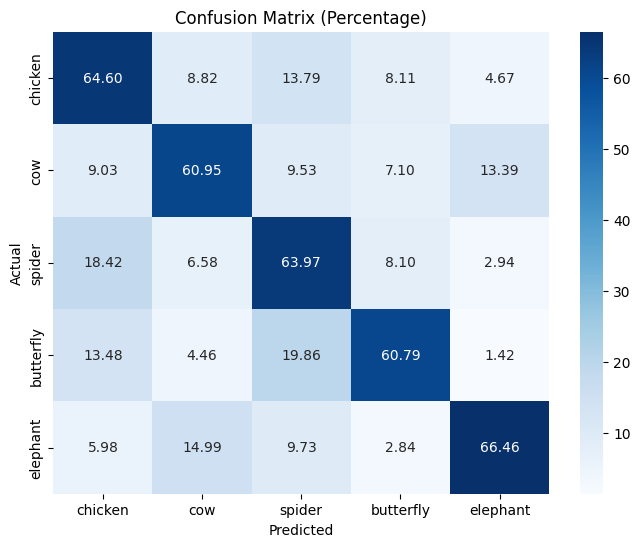

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        embeddings = model(images)

        # Compute distance to prototypes
        dists = torch.cdist(embeddings, prototypes)
        preds = torch.argmin(dists, dim=1)

        y_true.append(labels.item())
        y_pred.append(preds.item())

# Convert to NumPy
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Normalize by row (percentage)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Percentage)")
plt.show()
